# Histopathologic Cancer Detection using CNN

## Overview

In this project, we are tasked with creating a deep learning model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The ability to quickly detect cancer with high accuracy can significantly help with cancer diagnoses. In this notebook we will be:
1. Describing the challenge problem and dataset
2. Do Exploratory Data Analysis (EDA)
3. Describing the Deep Learning Model Architecture
4. Analyze Results
5. Talk about learnings at takeaways

First off, we will be importing some of the common libraries needed such as pandas, numpy, matplotlib and tensorflow.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


Next we check the tensorflow and keras versions and see if it detects the GPU.

In [94]:
print(tf.__version__)
print(keras.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

2.6.0
2.6.0
True
True


Testing and traing paths are created for importing and exporting images.

In [4]:
train_path = '../CancerDetection/train_data/train/'
test_path = '../CancerDetection/test/'

## Dataset and the Problem

Here we will import the data for the training labels. As seen below, there are a total of 220025 entries in the dataset. For the training_data dataset, there are two columns. One column is the id of the image. The second column is named label. If the label is 0, then the image does not contain cancer. If the label is 1, then the image does contain cancer. For this notebook, we are to use the training dataset to train a deep learning model that will be able to predict if any of the test images contain cancer or not.

In [5]:
training_data = pd.read_csv('train_labels.csv')

In [6]:
training_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


We see the ids and what they are labeled but now let's look at what the actual images look like. Below, we can see a sample of 9 different images that are labeled if they contain cancer or not. 

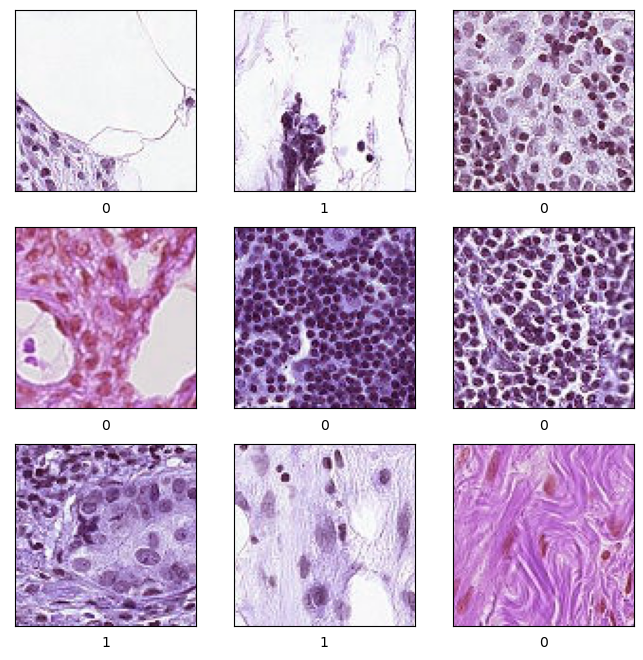

In [95]:
import cv2
# from skimage import io
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, axis in enumerate(ax.flat):
    img_array = cv2.imread(os.path.join(train_path,training_data.id[i] + '.tif'))
    axis.imshow(img_array)
    axis.set(xticks=[], yticks=[], xlabel = training_data.label[i]);

## Exploratory Data Analysis

Let's take a closer look at the contents of the data. We see that there are 130908 images that do not contain cancer and 89117 images that do. 

In [8]:
label_count = training_data['label'].value_counts()
print(label_count)

0    130908
1     89117
Name: label, dtype: int64


Next we have a bar graph and a pie chart to give us a comparison of the number of images that do and do not contain cancer. As a percentage, 59% of the images in the training dataset do not contain cancer while 41% of the images do contain cancer.

[Text(0.5, 1.0, 'Label Counts')]

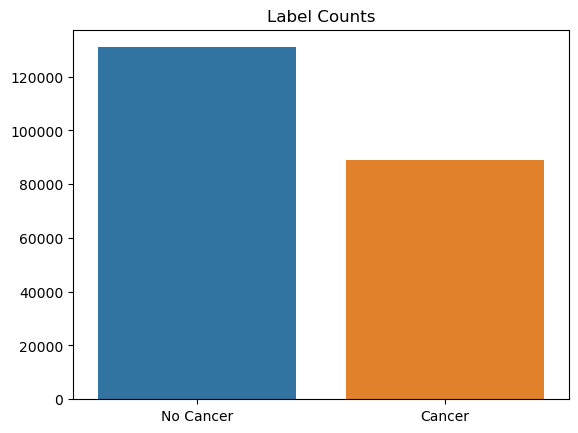

In [9]:
import seaborn as sns
label = ['No Cancer', 'Cancer']
freq = [130908,89117]
sns.barplot(x = label, y = freq).set(title = 'Label Counts')

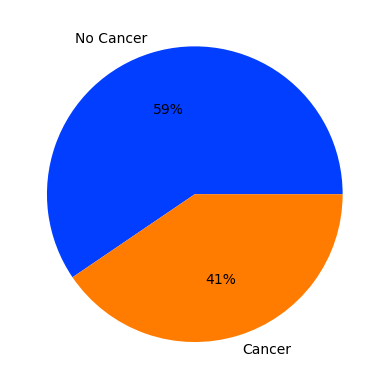

In [10]:
colors = sns.color_palette('bright')[0:5]
plt.pie(freq, labels = label, colors = colors, autopct='%.0f%%')
plt.show()

Since we have a slight imbalance to the training dataset, we will be reducing the number of images that do not contain cancer down to the same number of images that contain cancer. We will also be shuffling around the entries to make sure the images that are removed from the training data are random. Below, we see that there are now 89117 images that contain cancer and 89117 images that do not contain cancer.

In [11]:
from sklearn.utils import shuffle

no_cancer = training_data[training_data['label'] == 0]
cancer = training_data[training_data['label'] == 1]
no_cancer = shuffle(no_cancer, random_state = 55)
no_cancer = no_cancer.head(89117)
even_training_data = cancer.append(no_cancer, ignore_index = True)
even_training_data = shuffle(even_training_data, random_state = 555)
even_training_data['label'].value_counts()

C:\Users\Kevin Chen\AppData\Local\Temp\ipykernel_15932\2055600378.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_training_data = cancer.append(no_cancer, ignore_index = True)


1    89117
0    89117
Name: label, dtype: int64

## Deep Learning Model Architecture and Results and Analysis

Now we get to building the deep learning model. We will be using Keras to build our convoluntional neural network. The first thing to do is to add the '.tif' to the back of all of the image ids since the files are images.

In [12]:
even_training_data['id.tif'] = even_training_data['id'].astype(str) + '.tif'
even_training_data['label'] = even_training_data['label'].astype(str)
even_training_data.head(2)

,id,label,id.tif
84236,9bc8abe57d052c55d9cce6948fd00fe22a893414,1,9bc8abe57d052c55d9cce6948fd00fe22a893414.tif
142081,235af100c93a9551c84a782724dca9e796bc3f3e,0,235af100c93a9551c84a782724dca9e796bc3f3e.tif


Next we use ImageDataGenerator and flow_from_dataframe to create our datasets. There will be a training dataset and a validation dataset. 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
batch_size = 32

In [16]:
train_ds = datagen.flow_from_dataframe(
    even_training_data,
    directory = train_path,
    x_col = 'id.tif',
    y_col = 'label',
    target_size = (96,96),
    class_mode = 'binary',
    subset = 'training',
    batch_size = batch_size,
    seed = 1337
    )

Found 142588 validated image filenames belonging to 2 classes.


In [18]:
val_ds = datagen.flow_from_dataframe(
    even_training_data,
    directory = train_path,
    x_col = 'id.tif',
    y_col = 'label',
    target_size = (96,96),
    class_mode = 'binary',
    subset = 'validation',
    batch_size = batch_size,
    seed = 1337
    )

Found 35646 validated image filenames belonging to 2 classes.


### Initial Model

Here we build the initial model. The initial model will be a sequential model with:
1. Convolutional Layer with Relu Activation
2. Convolutional Layer with Relu Activation
3. Max Pooling Layer
4. Convolutional Layer with Relu Activation
5. Convolutional Layer with Relu Activation
6. Max Pooling Layer
7. Flatten Layer
8. Dense Layer
9. Sigmoid Activation

In all, there will be 30,769 parameters. This model architecture is consistant with the common Convolutional Layer -> Convolutional Layer -> Max Pool basic setup of a convolutional neural network. In this case, we have two in this setup.

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [28]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 16, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.build(input_shape = (batch_size, 96,96,3))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy', tf.keras.metrics.FalseNegatives(),
                        tf.keras.metrics.FalsePositives()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (32, 94, 94, 16)          448       
_________________________________________________________________
activation_18 (Activation)   (32, 94, 94, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (32, 92, 92, 16)          2320      
_________________________________________________________________
activation_19 (Activation)   (32, 92, 92, 16)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 46, 46, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (32, 44, 44, 32)          4640      
_________________________________________________________________
activation_20 (Activation)   (32, 44, 44, 32)         

After building the model, we can finally train the model. For this exercise, we will be using 10 epochs. As for tracking metrics, we will be tracking accuracy, loss, false positives, and false negatives.

In [29]:
epoch = 10
run_model = model.fit(train_ds, epochs = epoch, validation_data = val_ds, verbose = 1)

Epoch 1/10
4456/4456 [==============================] - 134s 30ms/step - loss: 0.4452 - accuracy: 0.7956 - false_negatives_4: 15408.0000 - false_positives_4: 13738.0000 - val_loss: 0.4045 - val_accuracy: 0.8163 - val_false_negatives_4: 4953.0000 - val_false_positives_4: 1596.0000
Epoch 2/10
4456/4456 [==============================] - 138s 31ms/step - loss: 0.3649 - accuracy: 0.8434 - false_negatives_4: 13253.0000 - false_positives_4: 9078.0000 - val_loss: 0.3420 - val_accuracy: 0.8515 - val_false_negatives_4: 3819.0000 - val_false_positives_4: 1474.0000
Epoch 3/10
4456/4456 [==============================] - 130s 29ms/step - loss: 0.3199 - accuracy: 0.8646 - false_negatives_4: 11707.0000 - false_positives_4: 7597.0000 - val_loss: 0.2891 - val_accuracy: 0.8790 - val_false_negatives_4: 2630.0000 - val_false_positives_4: 1682.0000
Epoch 4/10
4456/4456 [==============================] - 137s 31ms/step - loss: 0.2930 - accuracy: 0.8780 - false_negatives_4: 10636.0000 - false_positives_4: 6

After running the model, we can see an accuracy of 0.9152 with a validation accuracy of 0.8963. As seen in the accuracy chart below, there is a bit of overfitting going on. When it comes to false positives and false negative as a percentage, there is some noise but overall looks to have a downward trend with the false negative graph much more obvious than the false positive graph. Not a bad first try. Let's see if we can improve our model.

In [32]:
#create epoch_lst for x axis on charts below
epoch_lst = list(range(1, epoch + 1))

In [33]:
#creates dataframe for accuracy vs epoch
accuracy = pd.DataFrame(list(zip(epoch_lst, run_model.history['accuracy'], 
                        run_model.history['val_accuracy'])), 
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])

In [62]:
#creates dataframe for loss vs epoch
loss = pd.DataFrame(list(zip(epoch_lst, run_model.history['loss'], 
                        run_model.history['val_loss'])), 
                        columns = ['Epoch','Loss', 'Val_Loss'])

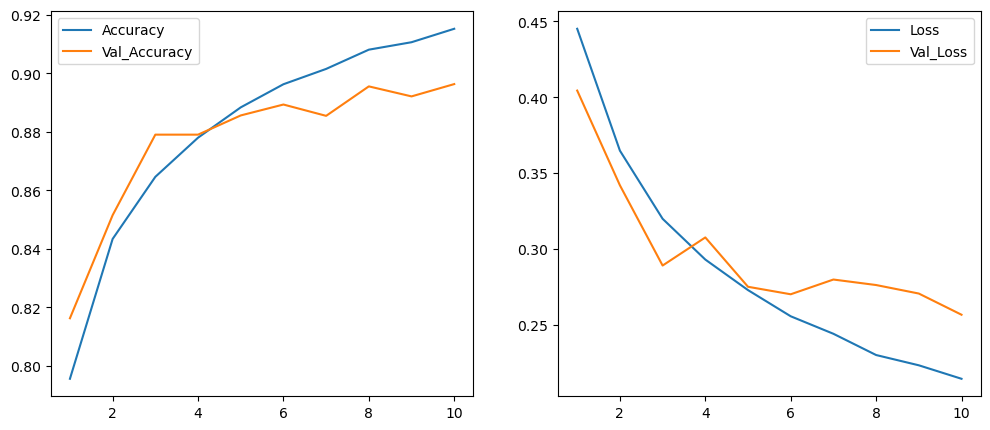

In [83]:
#plot accuracy vs epoch and loss vs epoch
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy['Epoch'], accuracy['Accuracy'])
ax1.plot(accuracy['Epoch'], accuracy['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss['Epoch'], loss['Loss'])
ax2.plot(loss['Epoch'], loss['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])


In [35]:
#create dataframe for false positive percentage vs epoch
false_positive = pd.DataFrame(list(zip(epoch_lst, run_model.history['false_positives_4'], 
                        run_model.history['val_false_positives_4'])), 
                        columns = ['Epoch','False_Positives', 'Val_False_Positives'])
#note: the false positive is divieded by the number of images in the training dataset and the
# validation dataset to get a percentage
false_positive['False_Positives'] = false_positive['False_Positives'].div(142588).round(3)
false_positive['Val_False_Positives'] = false_positive['Val_False_Positives'].div(35646).round(3)

In [37]:
#create dataframe for false negative percentage vs epoch
false_negative = pd.DataFrame(list(zip(epoch_lst, run_model.history['false_negatives_4'], 
                        run_model.history['val_false_negatives_4'])), 
                        columns = ['Epoch','False_Negatives', 'Val_False_Negatives'])
#note: the false positive is divieded by the number of images in the training dataset and the
# validation dataset to get a percentage
false_negative['False_Negatives'] = false_negative['False_Negatives'].div(142588).round(3)
false_negative['Val_False_Negatives'] = false_negative['Val_False_Negatives'].div(35646).round(3)


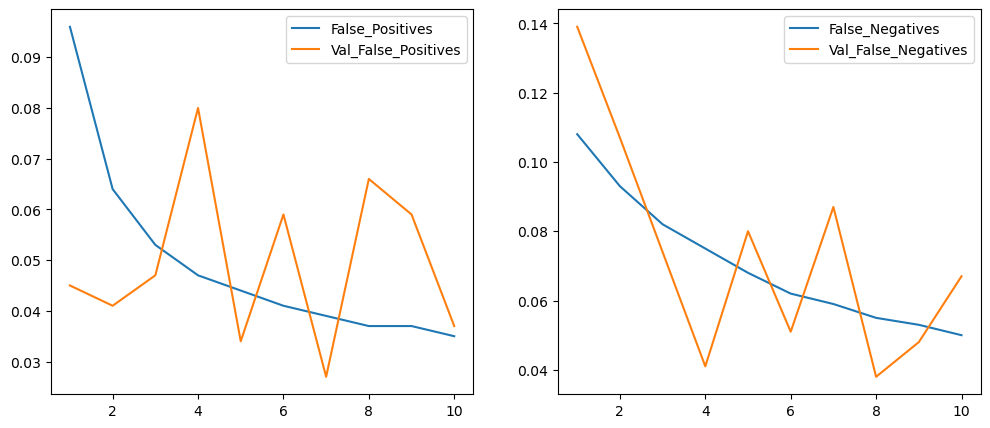

In [84]:
#create plot for false negative percentage vs epoch
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(false_positive['Epoch'], false_positive['False_Positives'])
ax1.plot(false_positive['Epoch'], false_positive['Val_False_Positives'])
ax1.legend(['False_Positives', 'Val_False_Positives'])

ax2.plot(false_negative['Epoch'], false_negative['False_Negatives'])
ax2.plot(false_negative['Epoch'], false_negative['Val_False_Negatives'])
ax2.legend(['False_Negatives', 'Val_False_Negatives'])

### Improved Model

The first model was a good first step. Now let's improve upon the previous model. In this second model, we will be experimenting with adding convulutional layers and filters as well methods to reduce overfitting such as dropout, batch normalization, and modifying the learning rate. Below, we have come up with a model that has improved upon the previous model. The number of filters in each convolutional layer has doubled and a dropout has been added after every max pool layer. The commented out code has been included to show some other hyperparameterse that were experimented with but did not make the final cut in the improved model. In the final product we have:

1. Convolutional Layer with Relu Activation
2. Convolutional Layer with Relu Activation
3. Max Pooling Layer
4. Dropout Layer
5. Convolutional Layer with Relu Activation
6. Convolutional Layer with Relu Activation
7. Max Pooling Layer
8. Dropout Layer
9. Flatten Layer
10. Dense Layer
11. Sigmoid Activation

In [55]:
from tensorflow.keras.optimizers import Adam

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (3,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(filters = 32, kernel_size = (3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.1))
# model2.add(BatchNormalization())

model2.add(Conv2D(filters = 64, kernel_size = (3,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.1))
# model2.add(BatchNormalization())

# model2.add(Conv2D(filters = 128, kernel_size = (3,3)))
# model2.add(Activation('relu'))
# model2.add(MaxPooling2D(pool_size = (2,2)))
# model2.add(Dropout(0.1))

model2.add(Flatten())
# model.add(Dense(64))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.build(input_shape = (batch_size, 96,96,3))

# opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy', tf.keras.metrics.FalseNegatives(),
                        tf.keras.metrics.FalsePositives()])
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (32, 94, 94, 32)          896       
_________________________________________________________________
activation_63 (Activation)   (32, 94, 94, 32)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (32, 92, 92, 32)          9248      
_________________________________________________________________
activation_64 (Activation)   (32, 92, 92, 32)          0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (32, 46, 46, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (32, 46, 46, 32)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (32, 44, 44, 64)        

In [56]:
epoch = 10
run_model2 = model2.fit(train_ds, epochs = epoch , validation_data = val_ds, verbose = 1)

Epoch 1/10
4456/4456 [==============================] - 144s 29ms/step - loss: 0.4333 - accuracy: 0.8041 - false_negatives_13: 15351.0000 - false_positives_13: 12575.0000 - val_loss: 0.3783 - val_accuracy: 0.8304 - val_false_negatives_13: 4461.0000 - val_false_positives_13: 1583.0000
Epoch 2/10
4456/4456 [==============================] - 128s 29ms/step - loss: 0.3451 - accuracy: 0.8528 - false_negatives_13: 12514.0000 - false_positives_13: 8470.0000 - val_loss: 0.3060 - val_accuracy: 0.8754 - val_false_negatives_13: 2292.0000 - val_false_positives_13: 2149.0000
Epoch 3/10
4456/4456 [==============================] - 129s 29ms/step - loss: 0.2977 - accuracy: 0.8762 - false_negatives_13: 10672.0000 - false_positives_13: 6983.0000 - val_loss: 0.2661 - val_accuracy: 0.8926 - val_false_negatives_13: 1951.0000 - val_false_positives_13: 1878.0000
Epoch 4/10
4456/4456 [==============================] - 128s 29ms/step - loss: 0.2705 - accuracy: 0.8897 - false_negatives_13: 9616.0000 - false_po

After running the model, we can see an accuracy of 0.9242 with a validation accuracy of 0.9083 which is higher than the last model. The loss of 0.1937 and validation loss of 0.2406 is also lower than that of the last model As seen in the accuracy chart below, there continues to be a bit of overfitting although it is slightly lower than before. When it comes to false positives and false negative as a percentage, the decrease is very similar to that of the last model. 

In [65]:
epoch_lst = list(range(1, epoch + 1))
accuracy2 = pd.DataFrame(list(zip(epoch_lst, run_model2.history['accuracy'], 
                        run_model2.history['val_accuracy'])), 
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])

In [68]:
loss2 = pd.DataFrame(list(zip(epoch_lst, run_model2.history['loss'], 
                        run_model2.history['val_loss'])), 
                        columns = ['Epoch','Loss', 'Val_Loss'])

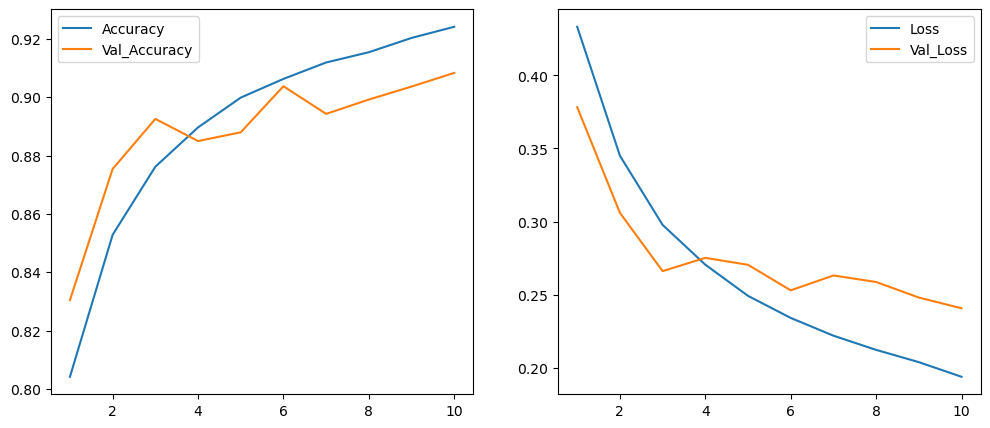

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy2['Epoch'], accuracy2['Accuracy'])
ax1.plot(accuracy2['Epoch'], accuracy2['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss2['Epoch'], loss2['Loss'])
ax2.plot(loss2['Epoch'], loss2['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])


In [57]:
false_positive2 = pd.DataFrame(list(zip(epoch_lst, run_model2.history['false_positives_13'], 
                        run_model2.history['val_false_positives_13'])), 
                        columns = ['Epoch','False_Positives', 'Val_False_Positives'])
false_positive2['False_Positives'] = false_positive2['False_Positives'].div(142588).round(3)
false_positive2['Val_False_Positives'] = false_positive2['Val_False_Positives'].div(35646).round(3)

In [60]:
false_negative2 = pd.DataFrame(list(zip(epoch_lst, run_model2.history['false_negatives_13'], 
                        run_model2.history['val_false_negatives_13'])), 
                        columns = ['Epoch','False_Negatives', 'Val_False_Negatives'])
false_negative2['False_Negatives'] = false_negative2['False_Negatives'].div(142588).round(3)
false_negative2['Val_False_Negatives'] = false_negative2['Val_False_Negatives'].div(35646).round(3)

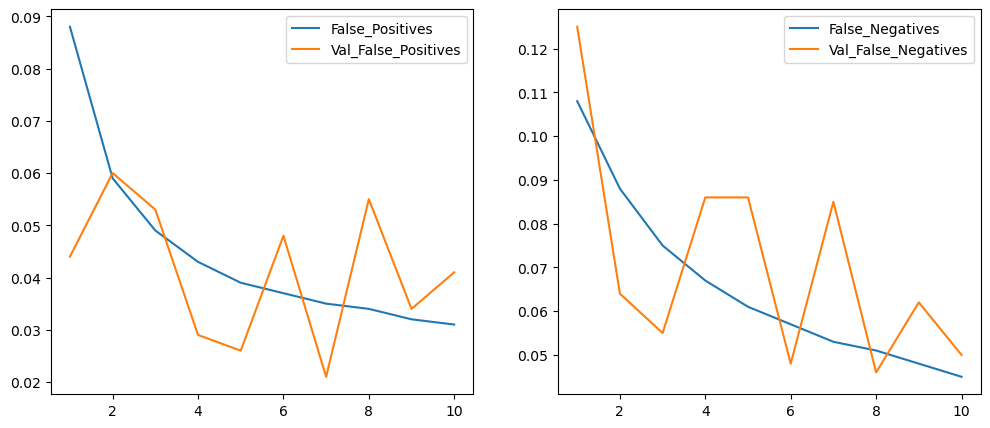

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(false_positive2['Epoch'], false_positive2['False_Positives'])
ax1.plot(false_positive2['Epoch'], false_positive2['Val_False_Positives'])
ax1.legend(['False_Positives', 'Val_False_Positives'])

ax2.plot(false_negative2['Epoch'], false_negative2['False_Negatives'])
ax2.plot(false_negative2['Epoch'], false_negative2['Val_False_Negatives'])
ax2.legend(['False_Negatives', 'Val_False_Negatives'])


### Submitting Results

After looking at the results, we find that that second model has performed better than the first model. Now we take the second model and generate a prediction dataset from the test data. We load the test images and use the improved model to make predictions.

In [86]:
#import the names of the 
test_lst = pd.DataFrame({'id':os.listdir(test_path)})

In [87]:
datagen = ImageDataGenerator(rescale = 1/255)
batch_size = 32

test_ds = datagen.flow_from_dataframe(
    test_lst,
    directory = test_path,
    x_col = 'id',
    y_col = None,
    target_size = (96,96),
    batchsize = 1,
    class_mode = None,
    seed = 1337
    )


Found 57458 validated image filenames.


In [88]:
y_hat = model2.predict(test_ds, verbose = 1) #train test data

1796/1796 [==============================] - 440s 245ms/step


In [89]:
y_hat.shape #make sure there are 57458 entries in the predicted data

(57458, 1)

In [93]:
#reformat the predicted data
test_lst['id'] = test_lst['id'].apply(lambda x: x.split('.')[0])
test_lst['label'] = list(map(lambda x: 0 if x < 0.5 else 1, y_hat))
test_lst.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [92]:
#export as .csv 
test_lst.to_csv('prediction.csv', index = False)  

## Conclusion and Takeaways

After going though this project, we created our first convolutional neural network and looked to improve upon it. We were able to import the images of healthy and metastatic tissue and use them to train a couple of convolutional neural networks. After training, the first neural network model, some hyperparameters such as filter layers were tweaked to try to increase the accuracy of the model. Other tweaks such as adding dropout layers, batch normalization, and chainging the learning curve were also considered to reduce overfitting. Overall, I felt that dropout worked better for preventing overfitting than changing the learning rate. Although we have been able to make a couple convolutional neural networks, there are still improvements out there that can be made. First off, the architecture of the neural network is relatively basic. There are many much more complicated convolutional neural networks out there such as VCG 16 and ResNet that can be used in this scenario. Other techniques that could have been explored would be to modify the images before training. For example, rotating images and/or flipping them backwards could have improved the classification accuracy of the neural network. Changing the images to grayscale would have been another technique I would like to try.